### Задача

Необходимо выполнить анализ датасета, применив полученные знания из пройденных тем. Для анализа могут быть выбраны любые данные: как уже готовые датасеты из Kaggle или любого другого источника, так и самостоятельно собранные данные.

#### Критерии
1. Сложность используемого датасета (1 балл) – датасет не должен быть "игрушечный", лучше, чтобы это были реальные данные, взятые из реального мира, максимально непредобработанные (например – логи посещения сайтов пользователями). В проекте можно работать как с одной таблицей, так и с несколькими.

2. Первичный анализ данных (1 балл) – изучить и описать, как были собраны данные, какие признаки, типы переменных есть в датасете. Описать, как будет происходить исследование, какая цель вашего проекта.

3. Предобработка данных (1 балла) – выполнить необходимую агрегацию данных, убрать лишние поля и объекты, дать пояснения, если в предобработке данных нет необходимости – написать, почему.

4. Визуальный анализ данных (2 балла) – использовать различные типы графиков, чтобы описать данные, все должно сопровождаться комментариями: какие зависимости или интересные инсайты были получены.

5. Проверка статистических гипотез (5 балла) - сформулировать статистические гипотезы в данных и проверить их с помощью статистических критериев (например - если это временной ряд, то изучить, изменились ли средние до и после определённого периода, или можно сравнить данные из разных групп)

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

import json
import chardet
import datetime
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Первичный анализ данных

Датасет состоит из данных, которые собирались в течение нескольких месяцев, об ежедневных трендовых видео (бралось до 200 экземпляров в день) на YouTube (делалось это с помощью YouTube API). Контент собирался по разным странам отдельно, я выбрала Российскую часть.

Датасет содержит такую информацию, как: название видео, название канала, время публикации, теги, просмотры, лайки и дизлайки, описание под роликом и количество комментариев.
comments_disabled - запрет на комментарии, их количество 0, если параметр True.
ratings_disabled - запрет на лайки\дизлайки, их количество 0, если параметр True.
video_error_or_removed - понятно
thunmnail_link - ссылки на превью-изображения.

Данные также включают поле category_id, и чтобы получить словесную категорию видео, нужно найти ее в связанном JSON файле.

In [2]:
with open('datasets/RUvideos.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [3]:
df = pd.read_csv('datasets/RUvideos_saved.csv',encoding='utf-8')

In [4]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,gDuslQ9avLc,17.14.11,Захар и Полина учатся экономить,Т—Ж БОГАЧ,22,2017-11-13T09:09:31.000Z,"захар и полина|""учимся экономить""|""копить день...",62408,334,190,50,https://i.ytimg.com/vi/gDuslQ9avLc/default.jpg,False,False,False,"Знакомьтесь, это Захар и Полина. Вместе с ними..."
1,AOCJIFEA_jE,17.14.11,Биржа Мемов #29. Большой выпуск,Druzhko Show,22,2017-11-13T17:32:11.000Z,"биржа мемов|""лев шагинян""|""мемы""|""пикчи""|""друж...",330043,43841,2244,2977,https://i.ytimg.com/vi/AOCJIFEA_jE/default.jpg,False,False,False,"В 29 выпуске Дружко Шоу Сергей сказал, что Бир..."
2,VAWNQDgwwOM,17.14.11,ХАЙП КЭМП - СВОЙ СРЕДИ ЧУЖИХ,Юлик,24,2017-11-13T16:11:31.000Z,"юмор|""комедия""|""влог""|""блог""|""смешно""|""смешное...",424596,49854,714,2944,https://i.ytimg.com/vi/VAWNQDgwwOM/default.jpg,False,False,False,http://kapitany.ru/!Yulik.cap - Факультет #Кап...
3,gknkFwKQfHg,17.14.11,Сочная кесадилья с курицей,Hochland,22,2017-11-13T06:51:10.000Z,"хохланд|""сыр""|""рецепты""|""как приготовить""|""вку...",112851,3566,122,80,https://i.ytimg.com/vi/gknkFwKQfHg/default.jpg,False,False,False,*** как готовить ресторанные блюда дома
4,3sYvZcwzZr8,17.14.11,КЛИПЫ РОДИТЕЛЕЙ НА ШКОЛЬНЫЙ ВЫПУСКНОЙ,Совергон,24,2017-11-13T16:52:36.000Z,"Совергон|""Sovergon""|""клипы""|""родители""|""школа""...",243469,36216,631,1692,https://i.ytimg.com/vi/3sYvZcwzZr8/default.jpg,False,False,False,❏ КОНКУРС КАПИТАНЫ: http://kapitany.ru/!Soverg...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40739 entries, 0 to 40738
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40739 non-null  object
 1   trending_date           40739 non-null  object
 2   title                   40739 non-null  object
 3   channel_title           40739 non-null  object
 4   category_id             40739 non-null  int64 
 5   publish_time            40739 non-null  object
 6   tags                    40739 non-null  object
 7   views                   40739 non-null  int64 
 8   likes                   40739 non-null  int64 
 9   dislikes                40739 non-null  int64 
 10  comment_count           40739 non-null  int64 
 11  thumbnail_link          40739 non-null  object
 12  comments_disabled       40739 non-null  bool  
 13  ratings_disabled        40739 non-null  bool  
 14  video_error_or_removed  40739 non-null  bool  
 15  de

In [6]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,40739.000000,4.073900e+04,4.073900e+04,40739.000000,40739.000000
mean,20.261936,2.407152e+05,1.243522e+04,1475.199612,1775.231179
std,7.890955,9.345111e+05,6.038280e+04,8582.480809,11275.028305
min,1.000000,1.170000e+02,0.000000e+00,0.000000,0.000000
25%,20.000000,2.258750e+04,4.025000e+02,31.000000,73.000000
50%,22.000000,6.631600e+04,1.880000e+03,128.000000,309.000000
75%,25.000000,1.951310e+05,7.791000e+03,586.000000,1107.000000
max,43.000000,6.279639e+07,4.470923e+06,884967.000000,905925.000000


### Предобработка данных
1. Поменяем тип у столбцов publish_time, trending_date на datetime, чтобы можно было сравнивать по времени.


In [7]:
with open('datasets/RU_category_id.json') as f:
    category = json.load(f)

In [8]:
df['publish_time'] = pd.to_datetime(df['publish_time'])

for j, i in enumerate(df['trending_date']):
    w = i.split('.')
    df.loc[j, ['trending_date']] = datetime.datetime(int('20' + w[0]),\
                           int(w[2]), int(w[1]))

2. Удалим столбцы, отвечающие за bool характеристики (ratings_disabled, omments_disabled), проверив, что пустые значения корректно заменяются,
3. Удалим поле thumbnail_link, дающее ссылку на фото-превью, и bool признак video_error_or_removed, потому что статистика от видео у нас осталась, значит можно рассматривать эти видео.

In [9]:
d1 = df[df.ratings_disabled == True]
d2 = df[df.comments_disabled == True]

if (all(d1.likes == 0) and all(d1.dislikes == 0) and all(d2.comment_count == 0)):
    df.drop(['ratings_disabled','comments_disabled', 'video_error_or_removed', \
         'thumbnail_link'], axis = 1, inplace = True)

4. Заменим поле category_id на данные из JSON файла, удалив те, что не было в JSON найдены.

In [10]:
category_id_title = dict()
for i, categ_real in enumerate(category['items']):
    category_id_title[int(categ_real['id'])] = categ_real['snippet']['title']

In [11]:
for i, categ_ref in enumerate(df.category_id):
    if (categ_ref not in category_id_title):
        df.drop([i], axis = 0, inplace = True)
    else:
        df.loc[i, ['category_id']] = category_id_title[categ_ref]

In [12]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,description
0,gDuslQ9avLc,2017-11-14 00:00:00,Захар и Полина учатся экономить,Т—Ж БОГАЧ,People & Blogs,2017-11-13 09:09:31+00:00,"захар и полина|""учимся экономить""|""копить день...",62408,334,190,50,"Знакомьтесь, это Захар и Полина. Вместе с ними..."
1,AOCJIFEA_jE,2017-11-14 00:00:00,Биржа Мемов #29. Большой выпуск,Druzhko Show,People & Blogs,2017-11-13 17:32:11+00:00,"биржа мемов|""лев шагинян""|""мемы""|""пикчи""|""друж...",330043,43841,2244,2977,"В 29 выпуске Дружко Шоу Сергей сказал, что Бир..."
2,VAWNQDgwwOM,2017-11-14 00:00:00,ХАЙП КЭМП - СВОЙ СРЕДИ ЧУЖИХ,Юлик,Entertainment,2017-11-13 16:11:31+00:00,"юмор|""комедия""|""влог""|""блог""|""смешно""|""смешное...",424596,49854,714,2944,http://kapitany.ru/!Yulik.cap - Факультет #Кап...
3,gknkFwKQfHg,2017-11-14 00:00:00,Сочная кесадилья с курицей,Hochland,People & Blogs,2017-11-13 06:51:10+00:00,"хохланд|""сыр""|""рецепты""|""как приготовить""|""вку...",112851,3566,122,80,*** как готовить ресторанные блюда дома
4,3sYvZcwzZr8,2017-11-14 00:00:00,КЛИПЫ РОДИТЕЛЕЙ НА ШКОЛЬНЫЙ ВЫПУСКНОЙ,Совергон,Entertainment,2017-11-13 16:52:36+00:00,"Совергон|""Sovergon""|""клипы""|""родители""|""школа""...",243469,36216,631,1692,❏ КОНКУРС КАПИТАНЫ: http://kapitany.ru/!Soverg...


## Визуальный анализ данных

Визуально оценим поведение датасета в видео-категориях:
1. Из какой категории чаще всего видео попадали в топ?
2. Коррелируют ли числовые признаки друг с другом?
3. Как числовые признаки соотносятся в среднем между собой в каждой категории?

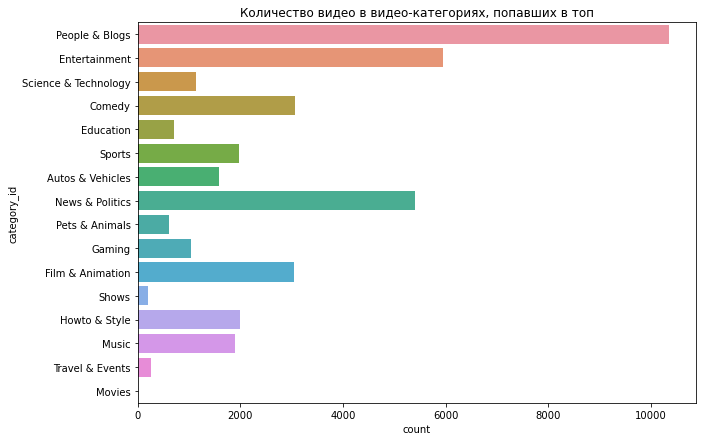

In [13]:
fig = plt.figure(figsize = (10, 7))

plt.title('Количество видео в видео-категориях, попавших в топ')
sns.countplot(y = df['category_id'])

По графику видно, что в топ чаще всего попадают видео из категории People & Blogs, причем отрыв по сравнению с другими категориями достаточно большой.

Рассмотрим зависимости признаки друг от друга. Например, есть ли корреляция между количеством просмотров и количеством дизлайков?

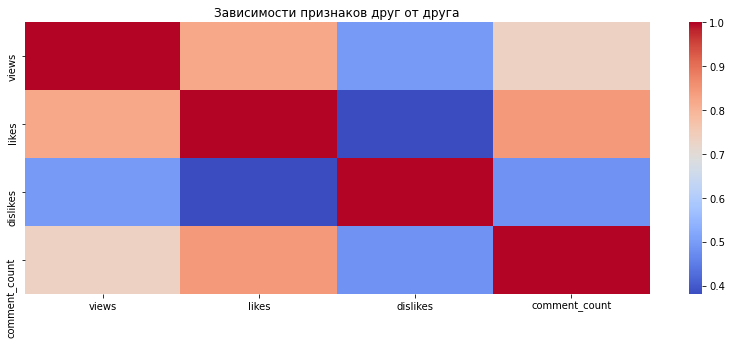

In [14]:
cols = ['views','likes','dislikes','comment_count']

fig = plt.figure(figsize = (14,5))
plt.title('Зависимости признаков друг от друга')
sns.heatmap(df[cols].corr(), cmap = 'coolwarm')

Логично было увидеть, что лайки будут зависеть от просмотров, не так очевидно, что они примерно также зависят от количества комментариев (аналогичые зависимости у количества просмотров и количества комментариев).

Интересно, что количество дизлайков практически никак ни с кем не коррелирует, причем от количества просмотров дизлайки зависят меньше, чем от количества комментариев (недовольство хочется обсудить?).

Оценим средние значения признаков в категориях.

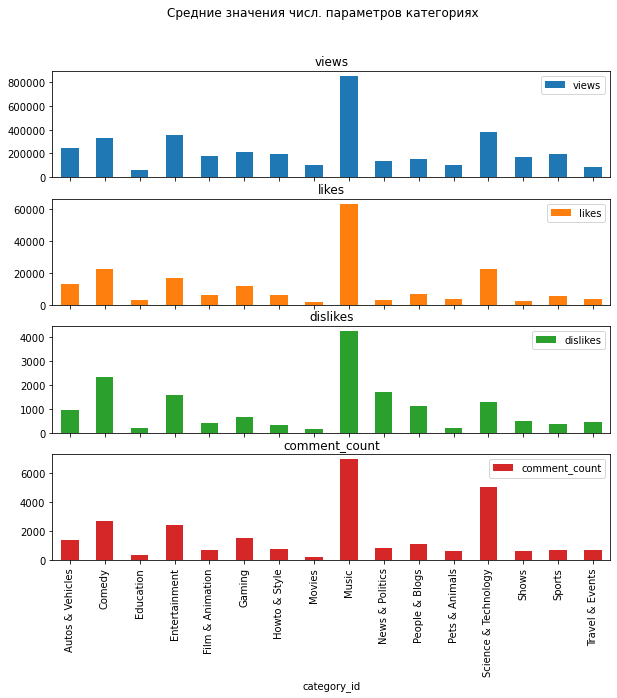

In [15]:
df.groupby(['category_id'])[cols].mean().plot.bar(figsize=(10,9), stacked = True,
                          title='Средние значения числ. параметров категориях', subplots = True)
plt.show()

Итого категория Music по всем параметрам получила, в среднем, больше всего лайков, просмотров, комментарив но и дизлайков (интересно, лидер не категория People & Blogs, которая чаще всего в топе появляется).

Минимум и по лайкам и по просмотрам занимает категория Education :)

## Проверка статистических гипотез



Проверим две статические гипотезы, связанные с категориями видео.


Возьмем две лидирующие по разным параметрам категории (Music, как лидер по числовым параметрам, и People & Blogs, как лидер по частоте попадания в топ).

**Задача.** Некоторый блогер думает, какую категорию поставить своему видео: Music или People & Blogs. И он знает статистику за последний месяц, что:
1. Первая категория попала в топ 8 раз, причем 3 из них превысило порог реакций (реакция - сумма количества всех лайков, дизлайков и комментариев; порог - низший предел отклика, который ютубер хочет получать),
2. Вторая категория попала в топ 37 раз, 12 из них соответствуют порогу.

Решить, какую категорию видео выставлять.

H0: доля реакций по двум категориям одинакова.

H1: доля реакций по People & Blogs категории больше, чем по Music категории.

При решении используется Z-критерий для несвязанных выборок.

In [16]:
df_last_month = df[df.trending_date >= datetime.datetime(2018, 6, 14)]
music_count = len(df_last_month[df_last_month.category_id == 'Music'])
blog_count = len(df_last_month[df_last_month.category_id == 'People & Blogs'])

print('Количество попавших в топ из Music категории - ', music_count)
print('Количество попавших в топ из People & Blogs категории - ', blog_count)

Количество попавших в топ из Music категории -  8
Количество попавших в топ из People & Blogs категории -  37


In [17]:
threshold = 8000
df_music = df_last_month[df_last_month.category_id == 'Music']
df_blogs = df_last_month[df_last_month.category_id == 'People & Blogs']
numb_music = df_music[df_music.likes + df_music.dislikes + df_music.comment_count > threshold]
numb_blogs = df_blogs[df_blogs.likes + df_blogs.dislikes + df_blogs.comment_count > threshold]

print('Количество прошедших по порогу из Music категории - ', len(numb_music))
print('Количество прошедших по порогу из People & Blogs категории - ', len(numb_blogs))

Количество прошедших по порогу из Music категории -  3
Количество прошедших по порогу из People & Blogs категории -  12


In [18]:
count = np.array([len(numb_music), len(numb_blogs)])
nobs = np.array([music_count, blog_count])
proportions_ztest(count, nobs, alternative = 'smaller')

(0.2757054832851778, 0.608612858121134)

Если у блогера есть информация только за последний месяц, а порог остается именно таким (8000 реакций любого характера), то нулевая гипотеза не отвергается (так как pvalue > 0.05), и, в среднем, доля реакций по двум категориям можно считать одинаковой.

Продолжим смотреть те же категории за последний месяц.

**Задача.** Хорошо, блогер выберет произвольную категорию по желанию. Есть ли разница, когда выкладывать видео? Есть ли разница между средним временем выкладывания видео в этих двух категориях?

H0: Среднее время выкладывания видео в категориях Music и People & Blogs одинаковое.

H1: Среднее время выкладывания видео в категориях Music и People & Blogs разное.

При решении используется критерий Манна-Уитни, т.к. выборки не связаны.

In [20]:
music_s = numb_music.trending_date - numb_music.publish_time
blog_s = numb_blogs.trending_date - numb_blogs.publish_time

In [21]:
stats.mannwhitneyu(music_s, blog_s, alternative='two-sided')

Заругался на несоответсвие дат друг-другу, исправить не успела, но идейно делается так, и как обычно, смотрим на pvalue и отбрасываем или оставляем нулевую гипотезу.